In [1]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

# Block on a slope

Try MPPI controller with a simple block on a slope.

*TODO*: add optional friction on the slope

In [41]:
def block_on_slope(block_mass, slope_angle, gravity_accel, desired_state, dt):
    # Apply a force parallel to the slope to achieve a desired position
    # and velocity of the block

    nx, nu = 2, 1

    def terminal_cost(x):
        return np.linalg.norm(desired_state - x)

    def state_cost(x):
        return np.linalg.norm(np.array([[1, 0], [0, 1e-2]]) @ (desired_state - x))

    def control_cost(u, sigma_inv, temp):
        base_controls = u[:nu]
        control_noise = u[nu:]

        return temp * np.dot(base_controls, np.dot(sigma_inv, control_noise))
    
#     def control_cost(u, sigma_inv, temp):
#         base_controls = u[:nu]
#         control_noise = u[nu:]
        
#         noisy_controls = base_controls + control_noise
        
#         R = np.diag([50])
        
#         return np.linalg.norm(noisy_controls.T @ R @ noisy_controls)

    def evolve_state(x_u, nx, nu, dt):
        x = x_u[:nx]
        pos, vel = x
        
        u = x_u[nx:]

        accel = (gravity_accel * np.sin(slope_angle)) + (u[0] / block_mass)

        evolved_state = np.array([
            pos + vel * dt + 0.5 * accel * (dt ** 2),
            vel + accel * dt
        ])
        
        return evolved_state

    def simulator(x, u):
        return evolve_state(np.hstack((x, u)), nx, nu, dt=dt)

    controller = MPPIController.MPPIController(
        n_rollouts=50,
        horizon_length=10,
        exploration_cov=np.array([[4 ** 2]]),
        exploration_lambda=1e-1,
        nx=nx,
        nu=nu,
        terminal_cost=terminal_cost,
        state_cost=state_cost,
        control_cost=control_cost,
        control_cov=np.array([[1]]),
        evolve_state=evolve_state,
        dt=dt
    )

    return controller, simulator

In [42]:
# Create the block on slope controller

sample_hz = 5
dt = 1 / sample_hz
desired_state = np.array([10, 0])

controller, simulator = block_on_slope(
    block_mass = 5, # kg
    slope_angle = np.radians(15), # radians
    gravity_accel = -9.81, # m / s^2
    desired_state = desired_state,
    dt = dt
)

[MPPI] [Warn] No control range input. Assuming [-inf, inf] on all dimensions.


In [47]:
# Create the control loop to run MPPI

current_state = np.array([0, 0])  # [position, velocity]
simulation_length = 10  # seconds

# Create some lists to hold plotted information
control_seq = []
xs = []

n_steps = int((1 / dt) * simulation_length)

for i in range(0, n_steps):
    next_u = controller.step(current_state)[0]
    control_seq.append(next_u[0])

    current_state = simulator(current_state, next_u)
    xs.append(current_state[0])

[Text(0.5, 0, 'time (s)'), Text(0, 0.5, 'force (N)')]

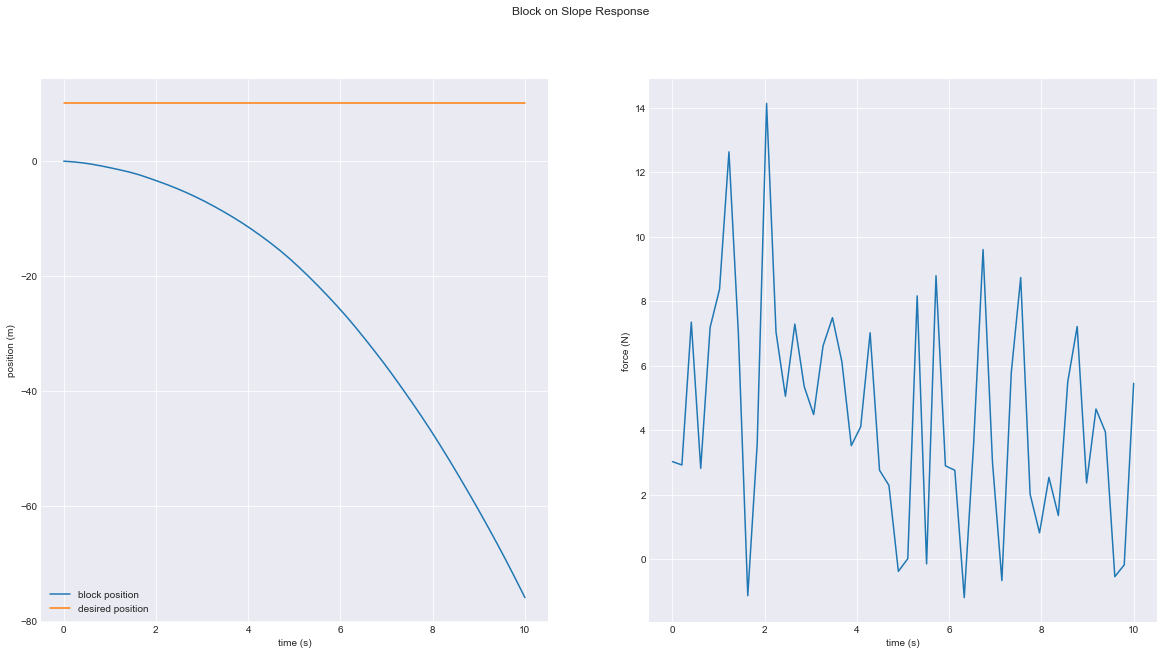

In [48]:
# Plot the results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Block on Slope Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, xs, label="block position")
ax1.plot(time, np.repeat(desired_state[0], n_steps), label="desired position")
ax1.set(xlabel="time (s)", ylabel="position (m)")
ax1.legend()

ax2.plot(time, control_seq, label="control")
ax2.set(xlabel="time (s)", ylabel="force (N)")

# 